I'm currently taking the [Plasma Physics MOOC from EPFL](https://courses.edx.org/courses/course-v1%3AEPFLx%2BPlasmaX%2BT12016/). One of the interesting aspects of the plasma state is that it is, over large scales, electrically neutral but on shorter scales indexed by the Debye length, locally non-neutral.

While discussing this over lunch running with a colleague, it occurred to me that this is something that can be nicely illustrated by a simulation using + and - charges. So this is what this notebook is about.

# Simulating a medium with + and - particles 

To simulate a medium, we just need a distribution of particles. Our distribution has a fundamental property: it has a scale by which the structure is measured. In our case, we will use a lattice of $(x,y)$ points that are all 1 unit apart. To make things look more realistic, we will add some gaussian noise on the order of .2 to each coordinate we draw.

In [1]:
import numpy as np

In [2]:
x_lattice_coords = np.arange(0, 100, 1.)
y_lattice_coords = np.arange(0, 80, 1.)

x, y = np.meshgrid(x_lattice_coords, y_lattice_coords)

We also define our center, for further use.

In [51]:
center = (50, 40)

Let's visualize our points:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
plt.style.use('bmh')

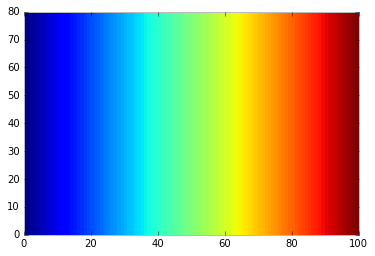

In [6]:
plt.pcolormesh(x)

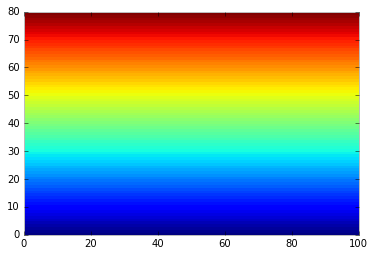

In [7]:
plt.pcolormesh(y)

Now, let's add a bit of noise to the lattice:

In [8]:
x += np.random.normal(size=x.shape)
y += np.random.normal(size=y.shape)

Our lattice is complete. Let's plot each point in it:

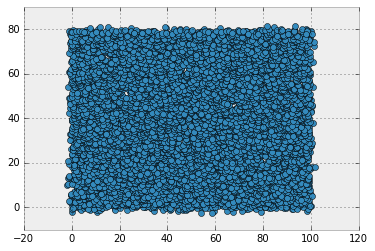

In [9]:
plt.plot(x.ravel(), y.ravel(), 'o')

Finally, let's assign some charges to our lattice. We do this by drawing random numbers between 0 and 1. Numbers above 0.5 get a + charge, while the others get a - charge.

In [10]:
charges = np.where(np.random.random(size=x.shape) > 0.5, 1, -1)

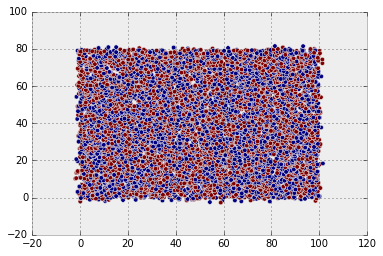

In [11]:
plt.scatter(x.ravel(), y.ravel(), c=charges.ravel())

As you can see, there's a lot of blue and red, meaning we've randomized the charges in a good manner.

The point of representing matter as a collection of particles over a square domain is to see what happens when we look into the matter from up close and what happens when we look at it from a distance. So let's zoom in!

# Zooming into the matter 

We will write a function that allows us to look at the previous plot in various ways.

In [12]:
from ipywidgets import interact

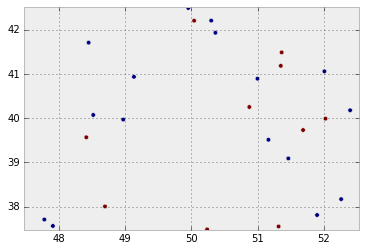

In [13]:
@interact
def zoom_in(box_size=(0.1, 10)):
    plt.scatter(x.ravel(), y.ravel(), c=charges.ravel())
    plt.xlim(center[0] - box_size / 2,
             center[0] + box_size / 2)
    plt.ylim(center[1] - box_size / 2,
         center[1] + box_size / 2)

It turns out we don't see the same thing when we look from up close at the charges and when we look from afar. We can do the following visualization to illustrate this point:

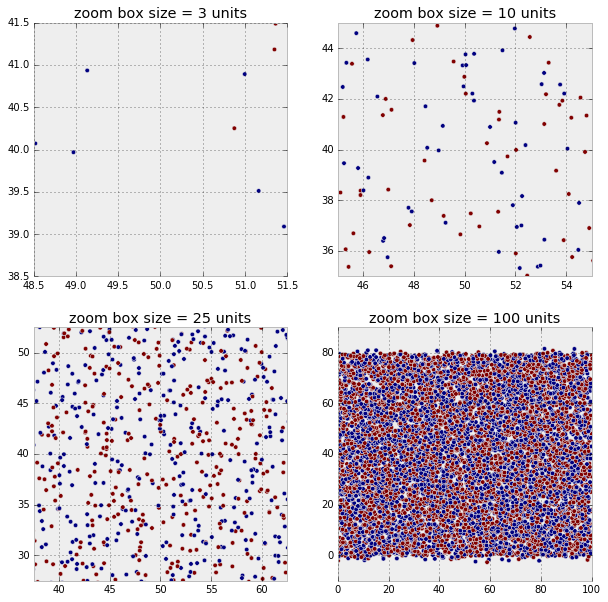

In [14]:
plt.figure(figsize=(10, 10))
for index, box_size in enumerate([3, 10, 25, 100]):
    plt.subplot(2, 2, index + 1)
    zoom_in(box_size)
    plt.title('zoom box size = {} units'.format(box_size))

In other words, the "average picture" or the "summed picture" of our particles depends on the scale we look at it.

We can animate this zooming effect easily using code by [Jake Vanderplas](http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/). To embed animations inside the notebook, we have to define the following functions:

In [15]:
from tempfile import NamedTemporaryFile
import base64 

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [16]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [17]:
from matplotlib import animation

In [18]:
FRAMES = 50
fig, ax = plt.subplots()

def init():
    ax.scatter(x.ravel(), y.ravel(), c=charges.ravel())
    
# animation function.  This is called sequentially
def animate(i):
    box_size = np.linspace(0.1, 50, num=FRAMES)[i]
    ax.set_xlim(center[0] - box_size / 2,
             center[0] + box_size / 2)
    ax.set_ylim(center[1] - box_size / 2,
         center[1] + box_size / 2)
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)

This gives us a better idea of what we're looking at, on average, which depends on the scale we look at it. To give a better illustration of this phenomenon, we will plot the summed charge in a circle with a fixed radius in the next section.

# Summing charges over a circular domain

Summing charges is quite easy. We compute the distance to the center of our cloud and sum all particles which are below a fixed radius:

In [19]:
def sum_charges(x, y, charges, radius):
    inside = np.sqrt((x - center[0])**2 + (y - center[1])**2) < radius
    return np.sum(charges[inside])

To better visualize this, we define the following function:

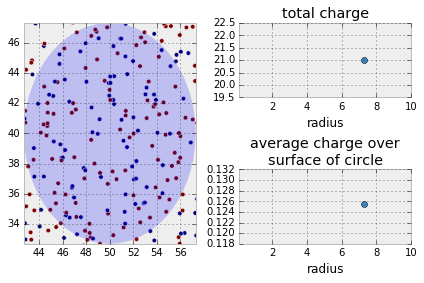

In [20]:
@interact
def visualize_charge_sum(radius=(0.1, 10)):
    plt.subplot(121)
    zoom_in(radius * 2)
    ax = plt.gca()
    ax.add_artist(plt.Circle(center, radius, alpha=0.2))
    plt.subplot(222)
    total_charge = sum_charges(x, y, charges, radius)
    plt.plot(radius, total_charge, 'o')
    plt.xlabel('radius')
    plt.title('total charge')
    plt.xlim(0.1, 10)
    plt.subplot(224)
    plt.plot(radius, total_charge / np.pi / radius**2, 'o')
    plt.xlabel('radius')
    plt.title('average charge over\nsurface of circle')
    plt.xlim(0.1, 10)
    plt.tight_layout()

We can produce a data animation using this code.

In [37]:
FRAMES = 50
MAX_DIAMETER = 50

fig = plt.figure(tight_layout=True)
ax_main = plt.subplot(121)
ax_top = plt.subplot(222)
ax_bot = plt.subplot(224)

def init():
    ax_main.scatter(x.ravel(), y.ravel(), c=charges.ravel())
    ax_top.set_xlim(0, MAX_DIAMETER/2)
    ax_bot.set_xlim(0, MAX_DIAMETER/2)
    ax_top.set_title('total charge')
    ax_bot.set_title('average charge over\nsurface of circle')
    ax_main.add_artist(plt.Circle(center, 0.1, alpha=0.2))
    
# animation function.  This is called sequentially
def animate(i):
    diameter = np.linspace(0.1, MAX_DIAMETER, num=FRAMES)[i]
    radius = diameter / 2
    ax_main.set_xlim(center[0] - diameter / 2,
             center[0] + diameter / 2)
    ax_main.set_ylim(center[1] - diameter / 2,
         center[1] + diameter / 2)
    ax_main.artists[0].remove()
    artist = ax_main.add_artist(plt.Circle(center, radius, alpha=0.2))
    
    total_charge = sum_charges(x, y, charges, radius)
    ax_top.plot(radius, total_charge, 'ok')
    ax_bot.plot(radius, total_charge / np.pi / radius**2, 'or')
    
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)

The takeaway from this animation is the following. Given a lattice dimension (1 unit here), there's a scale at which the lattice, with its randomness, is filtered in an averaged behaviour, with different properties. In particular, even if locally the total charge is not zero, it is on a larger scale as well as on average. Below, I annotate the previous two right hand side plots to highlight this phenomenon.

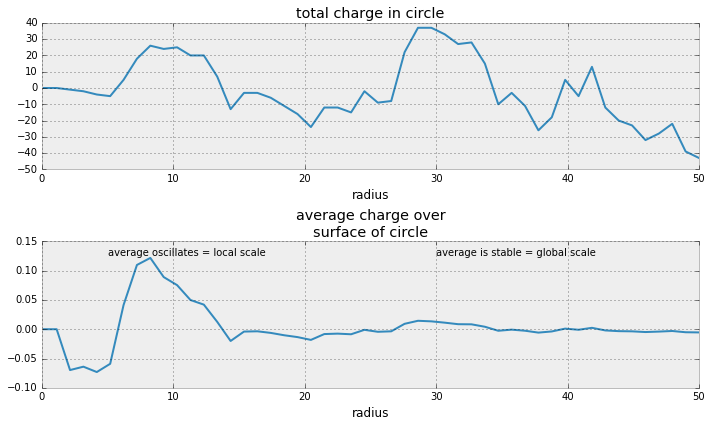

In [47]:
plt.figure(figsize=(10, 6))
radius = np.linspace(0.1, 50)
total_charge = [sum_charges(x, y, charges, r) for r in radius]
average_charge = np.array(total_charge) / (np.pi * radius **2)
plt.subplot(211)
plt.plot(radius, total_charge)
plt.xlabel('radius')
plt.title('total charge in circle')
plt.subplot(212)
plt.plot(radius, average_charge)
plt.xlabel('radius')
plt.title('average charge over\nsurface of circle')
plt.annotate('average oscillates = local scale', (5, 0.125))
plt.annotate('average is stable = global scale', (30, 0.125))
plt.tight_layout()

As one can see, the total charge still fluctuates while the average is already stable. If we zoom out further, we reach a point at which both the total charge and the average get stable.

Let's redo our whole experiment, only with a bigger lattice using the same lattice distance.

In [52]:
x_lattice_coords = np.arange(0, 1000, 1.)
y_lattice_coords = np.arange(0, 800, 1.)

x, y = np.meshgrid(x_lattice_coords, y_lattice_coords)

In [53]:
center = (500, 400)

In [54]:
x += np.random.normal(size=x.shape)
y += np.random.normal(size=y.shape)

In [55]:
charges = np.where(np.random.random(size=x.shape) > 0.5, 1, -1)

In [58]:
np.sum(charges)

518

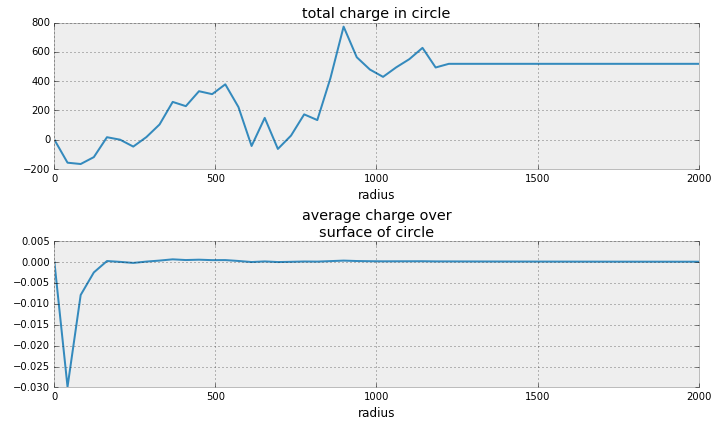

In [59]:
plt.figure(figsize=(10, 6))
radius = np.linspace(0.1, 2000)
total_charge = [sum_charges(x, y, charges, r) for r in radius]
average_charge = np.array(total_charge) / (np.pi * radius **2)
plt.subplot(211)
plt.plot(radius, total_charge)
plt.xlabel('radius')
plt.title('total charge in circle')
plt.subplot(212)
plt.plot(radius, average_charge)
plt.xlabel('radius')
plt.title('average charge over\nsurface of circle')
plt.annotate('average oscillates = local scale', (5, 0.125))
plt.annotate('average is stable = global scale', (30, 0.125))
plt.tight_layout()

It turns out that my lattice is biased: its total sum of charges is not zero!

In [60]:
np.sum(charges)

518

Let's conclude this exploration here. We've shown how a local fluctuation (left side of plots) becomes negligible while we zoom out (right side of plot), in particular when seen as an averaged property.

This local and global behaviour is often encountered in physics, not just in plasmas. In the next section, I mention two other relevant areas.

# There's more to this behaviour... 

It turns out that this basic principle is also what is at the core of [piezoelectricity](https://en.wikipedia.org/wiki/Piezoelectricity), a phenomenon I frequently encounter in my work on ultrasonic testing. To borrow an illustration of a 1d model of piezoelectricity:



In [23]:
from IPython.display import Image

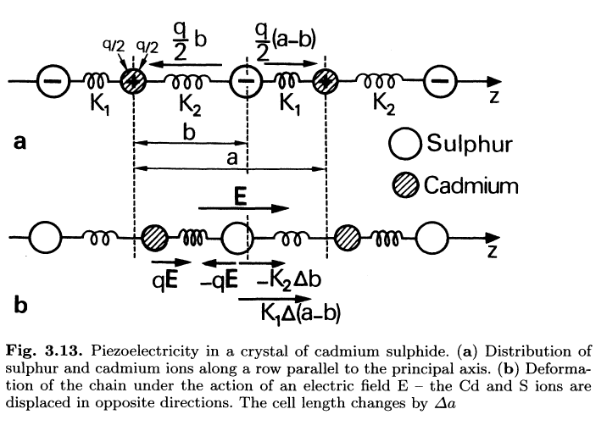

In [24]:
Image(filename='files/piezo.png')

Here, the assymetry comes from the difference in stiffness, not charge, of the atoms. But integrated over longer distances, this property emerges at a larger scale and gives rise to piezoelectricity.

Another area with a similar phenomenon is magnetism. As explained in the following video, magnetism is a quantum property that propagates in certain solids until the macroscopic scale where it has some real effects as in compasses, magnets...

In [48]:
from IPython.display import YouTubeVideo

In [50]:
YouTubeVideo('hFAOXdXZ5TM')